<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess mouse brain single-cell data from Zhao 2020 Nat Comm

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import os
from datetime import date
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3

In [3]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [4]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

Downloaded from: https://singlecell.broadinstitute.org/single_cell/study/SCP829/aging-mouse-brain-kolab?cluster=tSNE%20without%20batch%20correction&spatialGroups=--&annotation=orig.ident--group--study&subsample=all#study-download 06/03/2023

In [5]:
from scipy.io import mmread
matrix = mmread(main_dir+"\\P6_vasc_scRNAseq\Zhao2020\\gene_sorted-matrix.mtx.gz")

In [6]:
matrix.T

<72543x19746 sparse matrix of type '<class 'numpy.float64'>'
	with 58404382 stored elements in COOrdinate format>

In [7]:
obs = pd.read_table(main_dir+"\\P6_vasc_scRNAseq\Zhao2020\\barcodes.tsv", header=None)
var = pd.read_table(main_dir+"\\P6_vasc_scRNAseq\Zhao2020\\genes.tsv", header=None)

In [8]:
ad = sc.AnnData(matrix.T, obs=obs, var=var)
ad
ad.X = ad.X.todense() # COOrdinate format not subsettable 

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_7520\3214547395.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(matrix.T, obs=obs, var=var)
D:\Programme\Anaconda\envs\squidpy\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
del matrix
del obs
del var

In [10]:
ad.obs.index = ad.obs[0]
ad.obs.head()

0
0                                       
B1_AAACGGGGTAGTGAAT  B1_AAACGGGGTAGTGAAT
B1_AAAGATGGTCCGAGTC  B1_AAAGATGGTCCGAGTC
B1_AAAGCAAGTACCTACA  B1_AAAGCAAGTACCTACA
B1_AAAGCAAGTAGGCATG  B1_AAAGCAAGTAGGCATG
B1_AAAGCAAGTCCTCTTG  B1_AAAGCAAGTCCTCTTG

In [11]:
all(ad.var[0] == ad.var[1])

True

In [12]:
ad.var_names = ad.var[0]
ad.var_names

Index(['Rp1', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Rb1cc1', '4732440D04Rik', 'Pcmtd1',
       ...
       'C330002G04Rik', 'Mlana', 'Ffar4', 'Ankrd2', 'Gm16541', 'Hpse2',
       'Gm45352', 'AC133103.1', 'Gm10931', 'AC125149.2'],
      dtype='object', length=19746)

In [13]:
# add metadata
meta = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\Zhao2020\\meta.csv", sep=",", skiprows=[1])
meta.index = meta["NAME"]
meta.index.name = None
meta=meta.drop("NAME",axis=1)
meta.head()

orig.ident Batch  Age  nCount_RNA  nFeature_RNA  \
B1_AAACGGGGTAGTGAAT       old1     A  old        1030           534   
B1_AAAGATGGTCCGAGTC       old1     A  old        2624          1185   
B1_AAAGCAAGTACCTACA       old1     A  old        2721          1378   
B1_AAAGCAAGTAGGCATG       old1     A  old        3329          1413   
B1_AAAGCAAGTCCTCTTG       old1     A  old        2961          1318   

                     percent.mito  percent.ribo  
B1_AAACGGGGTAGTGAAT      0.076699      0.263107  
B1_AAAGATGGTCCGAGTC      0.027439      0.099466  
B1_AAAGCAAGTACCTACA      0.087835      0.090408  
B1_AAAGCAAGTAGGCATG      0.030039      0.151096  
B1_AAAGCAAGTCCTCTTG      0.039514      0.118541

In [14]:
assert all(ad.obs.index == meta.index)
ad.obs = meta
del meta
ad

AnnData object with n_obs × n_vars = 72543 × 19746
    obs: 'orig.ident', 'Batch', 'Age', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo'
    var: 0, 1

In [15]:
# add tsne and annotations
anno = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\Zhao2020\\tSNE_without_correction.csv", sep=",", skiprows=[1])
anno.index = anno["NAME"]
anno.index.name = None
anno=anno.drop("NAME",axis=1)
anno.head(3)

X          Y Celltype Subtype  seurat_clusters
B1_AAACGGGGTAGTGAAT -33.563921  -0.626164   imNeur     NaN               24
B1_AAAGATGGTCCGAGTC  10.670306  -7.006022       MG     NaN                8
B1_AAAGCAAGTACCTACA  20.513716  21.807308      EPC     NaN               25

In [16]:
anno.shape

(72543, 5)

In [17]:
ad.obs = ad.obs.join(anno)
del anno
ad.obs.head(3)

orig.ident Batch  Age  nCount_RNA  nFeature_RNA  \
B1_AAACGGGGTAGTGAAT       old1     A  old        1030           534   
B1_AAAGATGGTCCGAGTC       old1     A  old        2624          1185   
B1_AAAGCAAGTACCTACA       old1     A  old        2721          1378   

                     percent.mito  percent.ribo          X          Y  \
B1_AAACGGGGTAGTGAAT      0.076699      0.263107 -33.563921  -0.626164   
B1_AAAGATGGTCCGAGTC      0.027439      0.099466  10.670306  -7.006022   
B1_AAAGCAAGTACCTACA      0.087835      0.090408  20.513716  21.807308   

                    Celltype Subtype  seurat_clusters  
B1_AAACGGGGTAGTGAAT   imNeur     NaN               24  
B1_AAAGATGGTCCGAGTC       MG     NaN                8  
B1_AAAGCAAGTACCTACA      EPC     NaN               25

In [18]:
ad.obsm["X_tsne"] = np.array(ad.obs[["X","Y"]])

In [19]:
pd.value_counts(ad.obs["orig.ident"])

young4    15019
oldex4    11664
oldex1     9546
young2     9143
oldex2     7411
young1     7393
old2       5932
old4       5497
old1        938
Name: orig.ident, dtype: int64

In [20]:
pd.value_counts(ad.obs["Batch"])

C    32180
B    22486
A    17877
Name: Batch, dtype: int64

In [21]:
pd.value_counts(ad.obs["Age"])

young    31555
oldex    28621
old      12367
Name: Age, dtype: int64

In [22]:
pd.value_counts(ad.obs["Celltype"])

EC        20403
MG        19494
AC        16635
CPC        4251
OPC        3056
SMC        2424
MAC        1239
PC         1010
EPC         905
imNeur      889
NRP         495
mNeur       398
MNC         385
TNC         359
OLG         346
Hb_EC       254
Name: Celltype, dtype: int64

In [23]:
pd.value_counts(ad.obs["Subtype"])

VCap                5774
Cap                 4012
A2                  2832
A1                  2645
V                   2253
EC_unclassified     1881
aSMC                1166
AV                  1006
aaSMC                921
vSMC                 223
SMC_unclassified     114
Name: Subtype, dtype: int64

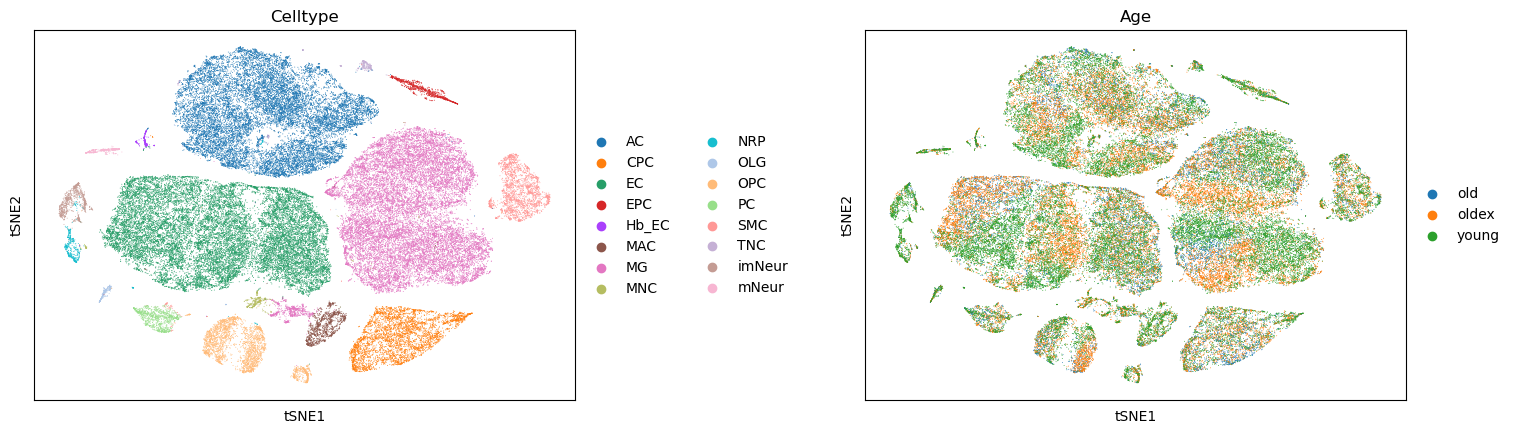

In [24]:
sc.pl.tsne(ad,color=["Celltype","Age"], wspace=0.4)

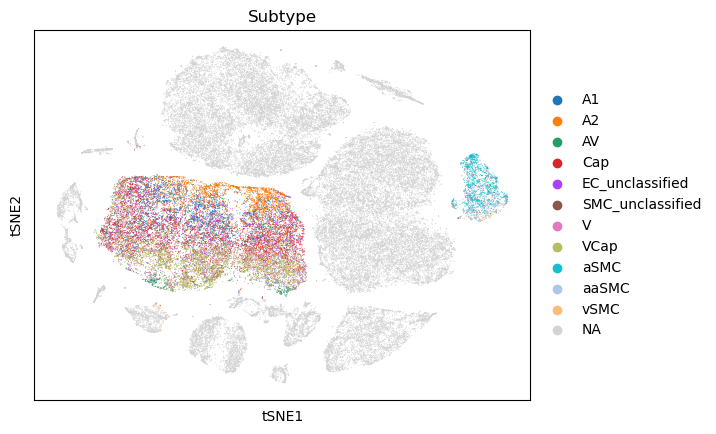

In [25]:
sc.pl.tsne(ad,color="Subtype")

In [26]:
# drop experimental condition
ad = ad[ad.obs['Age'].isin(['old', 'young'])]
ad

View of AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'Age', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'X', 'Y', 'Celltype', 'Subtype', 'seurat_clusters'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'

In [27]:
# re-name age groups

In [28]:
ad.obs['age2'] = ad.obs['Age']

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_7520\553186806.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age2'] = ad.obs['Age']


In [29]:
new_names = {
    '2-3m': {'young'},
    '18-20m': {'old'}
}
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'old': '18-20m', 'young': '2-3m'}


In [30]:
ad.obs['age'] = (
    ad.obs['age2']
    .map(new_cluster_names)
    .astype('category')
)

In [31]:
ad.obs['age']

B1_AAACGGGGTAGTGAAT    18-20m
B1_AAAGATGGTCCGAGTC    18-20m
B1_AAAGCAAGTACCTACA    18-20m
B1_AAAGCAAGTAGGCATG    18-20m
B1_AAAGCAAGTCCTCTTG    18-20m
                        ...  
B4_TTTGTCAGTTGCGCAC      2-3m
B4_TTTGTCAGTTTGACTG      2-3m
B4_TTTGTCATCAACGCTA      2-3m
B4_TTTGTCATCAGGCCCA      2-3m
B4_TTTGTCATCTTTAGGG      2-3m
Name: age, Length: 43922, dtype: category
Categories (2, object): ['18-20m', '2-3m']

In [32]:
ad.obs['age'] = ad.obs['age'].cat.reorder_categories(['2-3m', '18-20m'])

In [33]:
ad.obs=ad.obs.drop(["Age","X","Y"],axis=1)

In [34]:
pd.value_counts(ad.obs["age"])

2-3m      31555
18-20m    12367
Name: age, dtype: int64

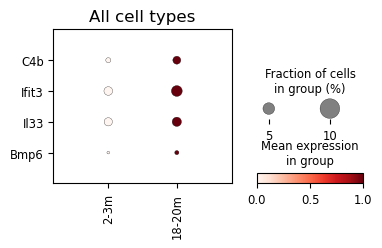

In [36]:
# verify that age groups are correct
# plot known genes upreglated during aging in mouse brain (Allen 2023 Cell)
sc.pl.dotplot(ad, ["C4b","Ifit3","Il33","Bmp6"], groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", title="All cell types")

In [37]:
pd.value_counts(ad.obs["Celltype"])

EC        12357
MG        11767
AC         9642
CPC        2560
OPC        1745
SMC        1425
MAC         888
imNeur      721
EPC         653
PC          642
NRP         414
mNeur       282
OLG         236
TNC         231
MNC         190
Hb_EC       169
Name: Celltype, dtype: int64

In [38]:
# also see paper

In [39]:
new_names = {
    'Endothelial cells': {'EC'},
    'Oligos': {'OLG'},
    'Astrocytes': {'AC'},
    'Pericytes': {'PC'},
    'SMCs': {'SMC'},
    'Neurons': {'imNeur','mNeur','NRP'},
    'OPCs': {'OPC'},
    'Microglia/Macrophages': {'MG','MAC','TNC'},
    'Ependymal cells': {'EPC','CPC'},
    'Immune_Other': {'MNC'},
    'Hemoglobin-expressing vascular cells':{'Hb_EC'},
}
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'AC': 'Astrocytes', 'CPC': 'Ependymal cells', 'EC': 'Endothelial cells', 'EPC': 'Ependymal cells', 'Hb_EC': 'Hemoglobin-expressing vascular cells', 'MAC': 'Microglia/Macrophages', 'MG': 'Microglia/Macrophages', 'MNC': 'Immune_Other', 'NRP': 'Neurons', 'OLG': 'Oligos', 'OPC': 'OPCs', 'PC': 'Pericytes', 'SMC': 'SMCs', 'TNC': 'Microglia/Macrophages', 'imNeur': 'Neurons', 'mNeur': 'Neurons'}


In [40]:
ad.obs['clusters'] = (
    ad.obs['Celltype']
    .map(new_cluster_names)
    .astype('category')
)

In [41]:
pd.value_counts(ad.obs["clusters"])

Microglia/Macrophages                   12886
Endothelial cells                       12357
Astrocytes                               9642
Ependymal cells                          3213
OPCs                                     1745
SMCs                                     1425
Neurons                                  1417
Pericytes                                 642
Oligos                                    236
Immune_Other                              190
Hemoglobin-expressing vascular cells      169
Name: clusters, dtype: int64

In [42]:
pd.value_counts(ad.obs["Subtype"])

VCap                3923
Cap                 2284
A2                  1677
A1                  1667
V                   1210
EC_unclassified     1074
aSMC                 658
aaSMC                545
AV                   522
vSMC                 145
SMC_unclassified      77
Name: Subtype, dtype: int64

In [43]:
new_names = {
    'vECs': {'V'},
    'capECs': {'Cap','VCap'},
    'aECs': {'A1','A2'},
    'SMCs': {'aSMC','aaSMC','vSMC','SMC_unclassified'},
    'ECs_unclassified': {'AV','EC_unclassified'},
}
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'A1': 'aECs', 'A2': 'aECs', 'AV': 'ECs_unclassified', 'Cap': 'capECs', 'EC_unclassified': 'ECs_unclassified', 'SMC_unclassified': 'SMCs', 'V': 'vECs', 'VCap': 'capECs', 'aSMC': 'SMCs', 'aaSMC': 'SMCs', 'vSMC': 'SMCs'}


In [44]:
ad.obs['subclusters'] = (
    ad.obs['Subtype']
    .map(new_cluster_names)
    .astype('category')
)

In [45]:
pd.value_counts(ad.obs["subclusters"])

capECs              6207
aECs                3344
ECs_unclassified    1596
SMCs                1425
vECs                1210
Name: subclusters, dtype: int64

In [46]:
ad.obs["clusters2"] = np.where(ad.obs["subclusters"].isna(), ad.obs["clusters"], ad.obs["subclusters"])

In [47]:
pd.value_counts(ad.obs["clusters2"])

Microglia/Macrophages                   12886
Astrocytes                               9642
capECs                                   6207
aECs                                     3344
Ependymal cells                          3213
OPCs                                     1745
ECs_unclassified                         1596
SMCs                                     1425
Neurons                                  1417
vECs                                     1210
Pericytes                                 642
Oligos                                    236
Immune_Other                              190
Hemoglobin-expressing vascular cells      169
Name: clusters2, dtype: int64

In [48]:
ad.var_names

Index(['Rp1', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Rb1cc1', '4732440D04Rik', 'Pcmtd1',
       ...
       'C330002G04Rik', 'Mlana', 'Ffar4', 'Ankrd2', 'Gm16541', 'Hpse2',
       'Gm45352', 'AC133103.1', 'Gm10931', 'AC125149.2'],
      dtype='object', length=19746)

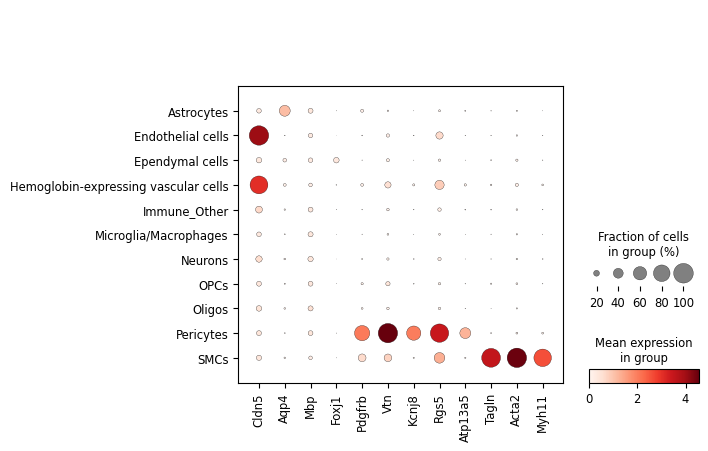

In [49]:
sc.pl.dotplot(ad, var_names=['Cldn5',"Aqp4","Mbp",'Foxj1','Pdgfrb','Vtn','Kcnj8','Rgs5','Atp13a5','Tagln','Acta2','Myh11'], groupby="clusters", swap_axes=False);

Last 3 cols are SMC markers

Check if data is normalized:

In [50]:
ad.layers

Layers with keys: 

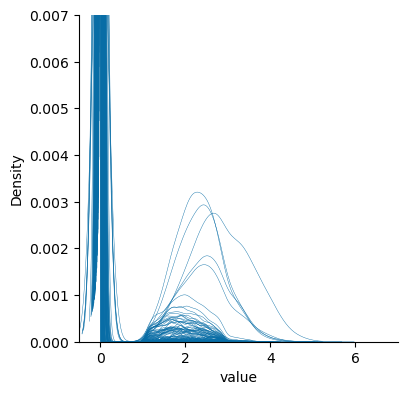

In [51]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

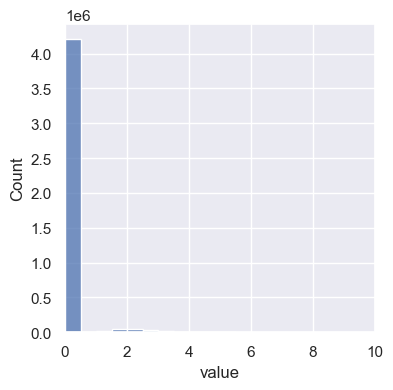

In [52]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
sns.set_style("ticks")
plt.show()

In [53]:
np.matrix(adata_sub.X)

matrix([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 2.4088764,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32)

Data seems to be normalized

In [54]:
ad.layers["normalized"] = ad.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

In [55]:
ad

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [56]:
ad.layers

Layers with keys: normalized

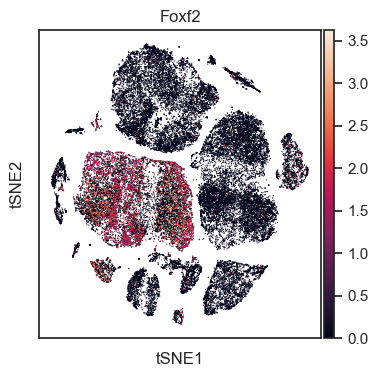

In [57]:
sc.pl.tsne(ad, color=['Foxf2'])

# Focus on: Foxf2

In [58]:
adata=ad
del ad

In [59]:
adata_backup = adata

In [60]:
# drop aged samples
# adata = adata[adata.obs['age'].isin(['2-3m'])]

In [61]:
gene="Foxf2"

## Plot

### Excl zonation

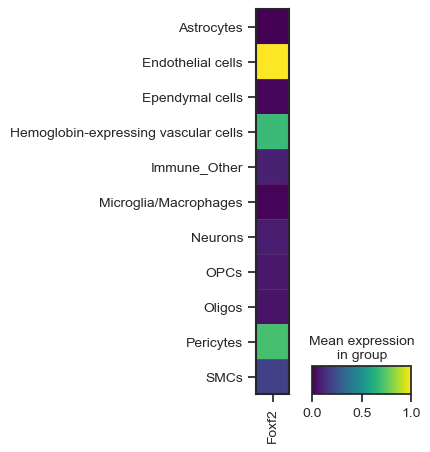

In [62]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

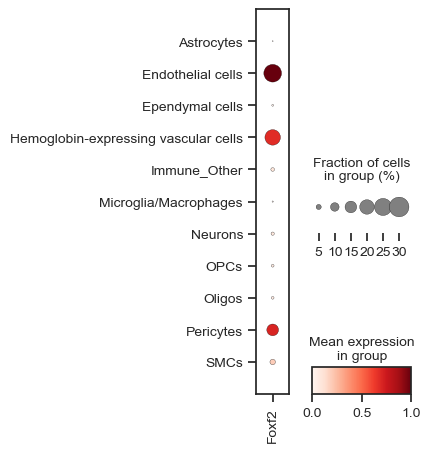

In [63]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [64]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                             
Astrocytes                                   0.000000
Endothelial cells                            1.000000
Ependymal cells                              0.019285
Hemoglobin-expressing vascular cells         0.677842
Immune_Other                                 0.090144
Microglia/Macrophages                        0.009758
Neurons                                      0.078675
OPCs                                         0.064222
Oligos                                       0.051511
Pericytes                                    0.703948
SMCs                                         0.190801

In [65]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                               
Astrocytes                                     0.004771
Endothelial cells                              0.260986
Ependymal cells                                0.012449
Hemoglobin-expressing vascular cells           0.218935
Immune_Other                                   0.031579
Microglia/Macrophages                          0.007605
Neurons                                        0.027523
OPCs                                           0.021777
Oligos                                         0.021186
Pericytes                                      0.151090
SMCs                                           0.054737

In [66]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  \
clusters                                                                   
Astrocytes                                   0.000000           0.004771   
Endothelial cells                            1.000000           0.260986   
Ependymal cells                              0.019285           0.012449   
Hemoglobin-expressing vascular cells         0.677842           0.218935   
Immune_Other                                 0.090144           0.031579   
Microglia/Macrophages                        0.009758           0.007605   
Neurons                                      0.078675           0.027523   
OPCs                                         0.064222           0.021777   
Oligos                                       0.051511           0.021186   
Pericytes                                    0.703948           0.151090   
SMCs                                         0.190801           0.054737   

                                       gene    source organism  cell_number  
clusters                                                                     
Astrocytes                            Foxf2  Zhao2020    Mouse         9642  
Endothelial cells                     Foxf2  Zhao2020    Mouse        12357  
Ependymal cells                       Foxf2  Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Foxf2  Zhao2020    Mouse          169  
Immune_Other                          Foxf2  Zhao2020    Mouse          190  
Microglia/Macrophages                 Foxf2  Zhao2020    Mouse        12886  
Neurons                               Foxf2  Zhao2020    Mouse         1417  
OPCs                                  Foxf2  Zhao2020    Mouse         1745  
Oligos                                Foxf2  Zhao2020    Mouse          236  
Pericytes                             Foxf2  Zhao2020    Mouse          642  
SMCs                                  Foxf2  Zhao2020    Mouse         1425

In [67]:
# export
name='Zhao2020'

In [68]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [69]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [70]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [71]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  \
clusters2                                                                  
Astrocytes                                   0.000000           0.004771   
ECs_unclassified                             0.947982           0.255013   
Ependymal cells                              0.018903           0.012449   
Hemoglobin-expressing vascular cells         0.664428           0.218935   
Immune_Other                                 0.088360           0.031579   
Microglia/Macrophages                        0.009565           0.007605   
Neurons                                      0.077118           0.027523   
OPCs                                         0.062951           0.021777   
Oligos                                       0.050492           0.021186   
Pericytes                                    0.690017           0.151090   
SMCs                                         0.187025           0.054737   
aECs                                         1.000000           0.270933   
capECs                                       0.987913           0.262446   
vECs                                         0.928521           0.233884   

                                       gene    source organism  cell_number  
clusters2                                                                    
Astrocytes                            Foxf2  Zhao2020    Mouse         9642  
ECs_unclassified                      Foxf2  Zhao2020    Mouse         1596  
Ependymal cells                       Foxf2  Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Foxf2  Zhao2020    Mouse          169  
Immune_Other                          Foxf2  Zhao2020    Mouse          190  
Microglia/Macrophages                 Foxf2  Zhao2020    Mouse        12886  
Neurons                               Foxf2  Zhao2020    Mouse         1417  
OPCs                                  Foxf2  Zhao2020    Mouse         1745  
Oligos                                Foxf2  Zhao2020    Mouse          236  
Pericytes                             Foxf2  Zhao2020    Mouse          642  
SMCs                                  Foxf2  Zhao2020    Mouse         1425  
aECs                                  Foxf2  Zhao2020    Mouse         3344  
capECs                                Foxf2  Zhao2020    Mouse         6207  
vECs                                  Foxf2  Zhao2020    Mouse         1210

In [72]:
# export
name='Zhao2020'

In [73]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [74]:
gene="Foxo1"

### Excl zonation

### Plot

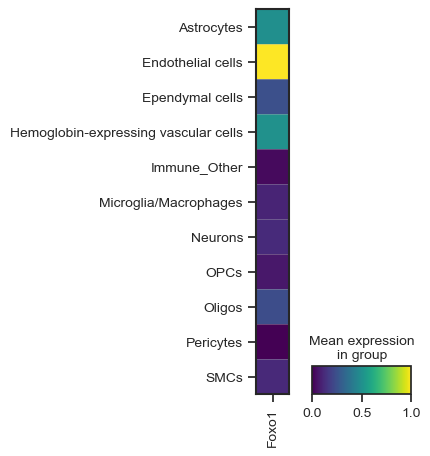

In [75]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

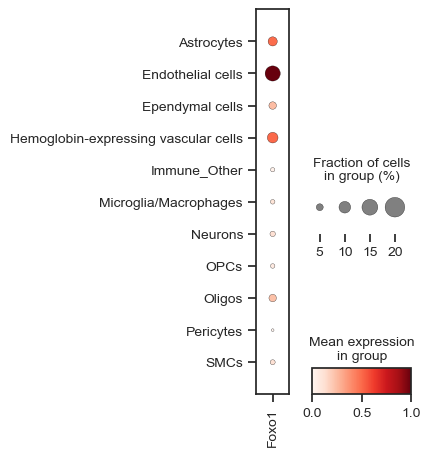

In [76]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [77]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                             
Astrocytes                                   0.493512
Endothelial cells                            1.000000
Ependymal cells                              0.243481
Hemoglobin-expressing vascular cells         0.500326
Immune_Other                                 0.026609
Microglia/Macrophages                        0.098349
Neurons                                      0.118211
OPCs                                         0.065569
Oligos                                       0.231291
Pericytes                                    0.000000
SMCs                                         0.116380

In [78]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                               
Astrocytes                                     0.072599
Endothelial cells                              0.141620
Ependymal cells                                0.055711
Hemoglobin-expressing vascular cells           0.088757
Immune_Other                                   0.026316
Microglia/Macrophages                          0.028558
Neurons                                        0.035992
OPCs                                           0.028080
Oligos                                         0.055085
Pericytes                                      0.014019
SMCs                                           0.032281

In [79]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  \
clusters                                                                   
Astrocytes                                   0.493512           0.072599   
Endothelial cells                            1.000000           0.141620   
Ependymal cells                              0.243481           0.055711   
Hemoglobin-expressing vascular cells         0.500326           0.088757   
Immune_Other                                 0.026609           0.026316   
Microglia/Macrophages                        0.098349           0.028558   
Neurons                                      0.118211           0.035992   
OPCs                                         0.065569           0.028080   
Oligos                                       0.231291           0.055085   
Pericytes                                    0.000000           0.014019   
SMCs                                         0.116380           0.032281   

                                       gene    source organism  cell_number  
clusters                                                                     
Astrocytes                            Foxo1  Zhao2020    Mouse         9642  
Endothelial cells                     Foxo1  Zhao2020    Mouse        12357  
Ependymal cells                       Foxo1  Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Foxo1  Zhao2020    Mouse          169  
Immune_Other                          Foxo1  Zhao2020    Mouse          190  
Microglia/Macrophages                 Foxo1  Zhao2020    Mouse        12886  
Neurons                               Foxo1  Zhao2020    Mouse         1417  
OPCs                                  Foxo1  Zhao2020    Mouse         1745  
Oligos                                Foxo1  Zhao2020    Mouse          236  
Pericytes                             Foxo1  Zhao2020    Mouse          642  
SMCs                                  Foxo1  Zhao2020    Mouse         1425

In [80]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [81]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [82]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [83]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  \
clusters2                                                                  
Astrocytes                                   0.436751           0.072599   
ECs_unclassified                             1.000000           0.161028   
Ependymal cells                              0.215477           0.055711   
Hemoglobin-expressing vascular cells         0.442781           0.088757   
Immune_Other                                 0.023548           0.026316   
Microglia/Macrophages                        0.087037           0.028558   
Neurons                                      0.104615           0.035992   
OPCs                                         0.058028           0.028080   
Oligos                                       0.204689           0.055085   
Pericytes                                    0.000000           0.014019   
SMCs                                         0.102994           0.032281   
aECs                                         0.828613           0.137261   
capECs                                       0.881856           0.139037   
vECs                                         0.905121           0.141322   

                                       gene    source organism  cell_number  
clusters2                                                                    
Astrocytes                            Foxo1  Zhao2020    Mouse         9642  
ECs_unclassified                      Foxo1  Zhao2020    Mouse         1596  
Ependymal cells                       Foxo1  Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Foxo1  Zhao2020    Mouse          169  
Immune_Other                          Foxo1  Zhao2020    Mouse          190  
Microglia/Macrophages                 Foxo1  Zhao2020    Mouse        12886  
Neurons                               Foxo1  Zhao2020    Mouse         1417  
OPCs                                  Foxo1  Zhao2020    Mouse         1745  
Oligos                                Foxo1  Zhao2020    Mouse          236  
Pericytes                             Foxo1  Zhao2020    Mouse          642  
SMCs                                  Foxo1  Zhao2020    Mouse         1425  
aECs                                  Foxo1  Zhao2020    Mouse         3344  
capECs                                Foxo1  Zhao2020    Mouse         6207  
vECs                                  Foxo1  Zhao2020    Mouse         1210

In [84]:
# export
name='Zhao2020'

In [85]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Tek = Tie2

In [86]:
gene="Tek"

### Excl zonation

### Plot

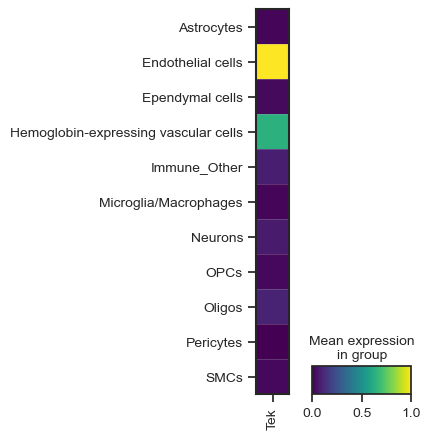

In [87]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

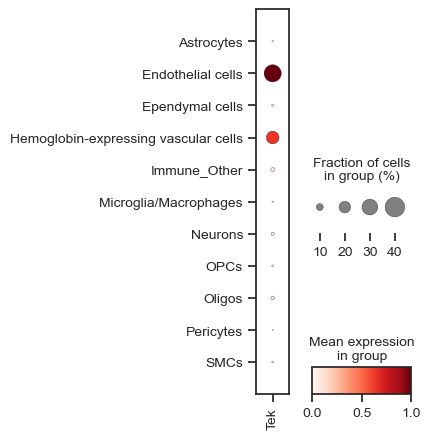

In [88]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [89]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                             
Astrocytes                                   0.014114
Endothelial cells                            1.000000
Ependymal cells                              0.026775
Hemoglobin-expressing vascular cells         0.638457
Immune_Other                                 0.085901
Microglia/Macrophages                        0.013087
Neurons                                      0.071288
OPCs                                         0.022372
Oligos                                       0.096150
Pericytes                                    0.000000
SMCs                                         0.022034

In [90]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                               
Astrocytes                                     0.012549
Endothelial cells                              0.335114
Ependymal cells                                0.020542
Hemoglobin-expressing vascular cells           0.224852
Immune_Other                                   0.047368
Microglia/Macrophages                          0.012960
Neurons                                        0.035286
OPCs                                           0.017192
Oligos                                         0.042373
Pericytes                                      0.007788
SMCs                                           0.017544

In [91]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells gene  \
clusters                                                                        
Astrocytes                                   0.014114           0.012549  Tek   
Endothelial cells                            1.000000           0.335114  Tek   
Ependymal cells                              0.026775           0.020542  Tek   
Hemoglobin-expressing vascular cells         0.638457           0.224852  Tek   
Immune_Other                                 0.085901           0.047368  Tek   
Microglia/Macrophages                        0.013087           0.012960  Tek   
Neurons                                      0.071288           0.035286  Tek   
OPCs                                         0.022372           0.017192  Tek   
Oligos                                       0.096150           0.042373  Tek   
Pericytes                                    0.000000           0.007788  Tek   
SMCs                                         0.022034           0.017544  Tek   

                                        source organism  cell_number  
clusters                                                              
Astrocytes                            Zhao2020    Mouse         9642  
Endothelial cells                     Zhao2020    Mouse        12357  
Ependymal cells                       Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Zhao2020    Mouse          169  
Immune_Other                          Zhao2020    Mouse          190  
Microglia/Macrophages                 Zhao2020    Mouse        12886  
Neurons                               Zhao2020    Mouse         1417  
OPCs                                  Zhao2020    Mouse         1745  
Oligos                                Zhao2020    Mouse          236  
Pericytes                             Zhao2020    Mouse          642  
SMCs                                  Zhao2020    Mouse         1425

In [92]:
# export
name='Zhao2020'

In [93]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [94]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [95]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [96]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells gene  \
clusters2                                                                       
Astrocytes                                   0.013015           0.012549  Tek   
ECs_unclassified                             0.941733           0.346491  Tek   
Ependymal cells                              0.024691           0.020542  Tek   
Hemoglobin-expressing vascular cells         0.588750           0.224852  Tek   
Immune_Other                                 0.079213           0.047368  Tek   
Microglia/Macrophages                        0.012068           0.012960  Tek   
Neurons                                      0.065738           0.035286  Tek   
OPCs                                         0.020630           0.017192  Tek   
Oligos                                       0.088664           0.042373  Tek   
Pericytes                                    0.000000           0.007788  Tek   
SMCs                                         0.020319           0.017544  Tek   
aECs                                         1.000000           0.367524  Tek   
capECs                                       0.881929           0.319478  Tek   
vECs                                         0.887452           0.310744  Tek   

                                        source organism  cell_number  
clusters2                                                             
Astrocytes                            Zhao2020    Mouse         9642  
ECs_unclassified                      Zhao2020    Mouse         1596  
Ependymal cells                       Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Zhao2020    Mouse          169  
Immune_Other                          Zhao2020    Mouse          190  
Microglia/Macrophages                 Zhao2020    Mouse        12886  
Neurons                               Zhao2020    Mouse         1417  
OPCs                                  Zhao2020    Mouse         1745  
Oligos                                Zhao2020    Mouse          236  
Pericytes                             Zhao2020    Mouse          642  
SMCs                                  Zhao2020    Mouse         1425  
aECs                                  Zhao2020    Mouse         3344  
capECs                                Zhao2020    Mouse         6207  
vECs                                  Zhao2020    Mouse         1210

In [97]:
# export
name='Zhao2020'

In [98]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

## Nos3 = eNOS

In [99]:
gene="Nos3"

### Excl zonation

### Plot

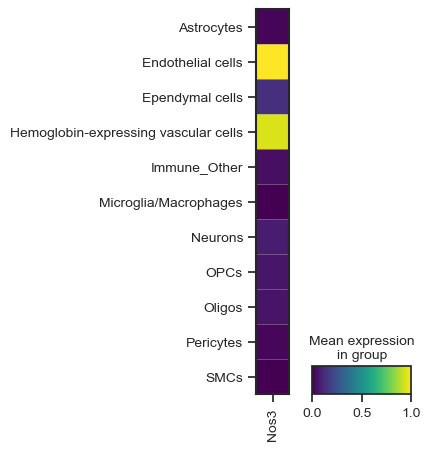

In [100]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

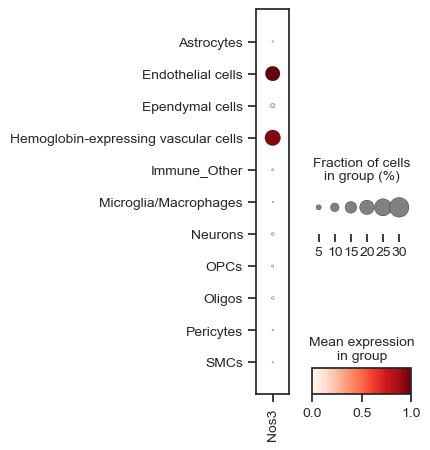

In [101]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [102]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                                             
Astrocytes                                   0.012621
Endothelial cells                            1.000000
Ependymal cells                              0.140457
Hemoglobin-expressing vascular cells         0.944422
Immune_Other                                 0.036638
Microglia/Macrophages                        0.001290
Neurons                                      0.075669
OPCs                                         0.054933
Oligos                                       0.053881
Pericytes                                    0.019297
SMCs                                         0.000000

In [103]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                               
Astrocytes                                     0.009438
Endothelial cells                              0.200696
Ependymal cells                                0.041706
Hemoglobin-expressing vascular cells           0.218935
Immune_Other                                   0.015789
Microglia/Macrophages                          0.007838
Neurons                                        0.021877
OPCs                                           0.016619
Oligos                                         0.021186
Pericytes                                      0.009346
SMCs                                           0.008421

In [104]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  \
clusters                                                                   
Astrocytes                                   0.012621           0.009438   
Endothelial cells                            1.000000           0.200696   
Ependymal cells                              0.140457           0.041706   
Hemoglobin-expressing vascular cells         0.944422           0.218935   
Immune_Other                                 0.036638           0.015789   
Microglia/Macrophages                        0.001290           0.007838   
Neurons                                      0.075669           0.021877   
OPCs                                         0.054933           0.016619   
Oligos                                       0.053881           0.021186   
Pericytes                                    0.019297           0.009346   
SMCs                                         0.000000           0.008421   

                                      gene    source organism  cell_number  
clusters                                                                    
Astrocytes                            Nos3  Zhao2020    Mouse         9642  
Endothelial cells                     Nos3  Zhao2020    Mouse        12357  
Ependymal cells                       Nos3  Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Nos3  Zhao2020    Mouse          169  
Immune_Other                          Nos3  Zhao2020    Mouse          190  
Microglia/Macrophages                 Nos3  Zhao2020    Mouse        12886  
Neurons                               Nos3  Zhao2020    Mouse         1417  
OPCs                                  Nos3  Zhao2020    Mouse         1745  
Oligos                                Nos3  Zhao2020    Mouse          236  
Pericytes                             Nos3  Zhao2020    Mouse          642  
SMCs                                  Nos3  Zhao2020    Mouse         1425

In [105]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [106]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True).values_df
ex.columns = ['mean_expression']

In [107]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True).dot_size_df
fc.columns = ['fraction_of_cells']

In [108]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Zhao2020"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  \
clusters2                                                                  
Astrocytes                                   0.011322           0.009438   
ECs_unclassified                             1.000000           0.221805   
Ependymal cells                              0.126001           0.041706   
Hemoglobin-expressing vascular cells         0.847221           0.218935   
Immune_Other                                 0.032867           0.015789   
Microglia/Macrophages                        0.001157           0.007838   
Neurons                                      0.067881           0.021877   
OPCs                                         0.049279           0.016619   
Oligos                                       0.048335           0.021186   
Pericytes                                    0.017311           0.009346   
SMCs                                         0.000000           0.008421   
aECs                                         0.917254           0.211423   
capECs                                       0.862494           0.192525   
vECs                                         0.882982           0.185124   

                                      gene    source organism  cell_number  
clusters2                                                                   
Astrocytes                            Nos3  Zhao2020    Mouse         9642  
ECs_unclassified                      Nos3  Zhao2020    Mouse         1596  
Ependymal cells                       Nos3  Zhao2020    Mouse         3213  
Hemoglobin-expressing vascular cells  Nos3  Zhao2020    Mouse          169  
Immune_Other                          Nos3  Zhao2020    Mouse          190  
Microglia/Macrophages                 Nos3  Zhao2020    Mouse        12886  
Neurons                               Nos3  Zhao2020    Mouse         1417  
OPCs                                  Nos3  Zhao2020    Mouse         1745  
Oligos                                Nos3  Zhao2020    Mouse          236  
Pericytes                             Nos3  Zhao2020    Mouse          642  
SMCs                                  Nos3  Zhao2020    Mouse         1425  
aECs                                  Nos3  Zhao2020    Mouse         3344  
capECs                                Nos3  Zhao2020    Mouse         6207  
vECs                                  Nos3  Zhao2020    Mouse         1210

In [109]:
# export
name='Zhao2020'

In [110]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation.csv',sep=';')

# Focus on: Aging

In [111]:
adata = adata_backup

In [112]:
pd.value_counts(adata.obs["age"])

2-3m      31555
18-20m    12367
Name: age, dtype: int64

## Foxf2 by age group

In [113]:
gene=["Foxf2","Foxo1","Tek","Nos3"]

### All cell types

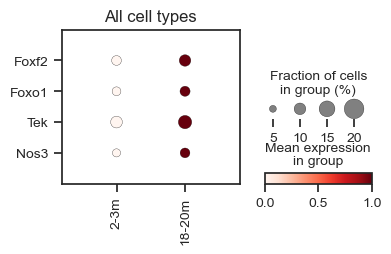

In [114]:
sc.pl.dotplot(adata, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="All cell types")

In [115]:
adata

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

### ECs only

In [116]:
# ECs only
adata_ecs = adata[adata.obs['clusters'].isin(['Endothelial cells'])]
adata_ecs

View of AnnData object with n_obs × n_vars = 12357 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [117]:
pd.value_counts(adata_ecs.obs["age"])

2-3m      8627
18-20m    3730
Name: age, dtype: int64

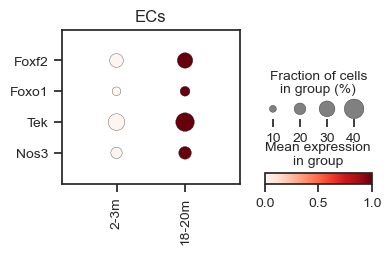

In [118]:
sc.pl.dotplot(adata_ecs, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="ECs")

### PCs only

In [119]:
adata_pcs = adata[adata.obs['clusters'].isin(['Pericytes'])]
pd.value_counts(adata_pcs.obs["age"])

2-3m      456
18-20m    186
Name: age, dtype: int64

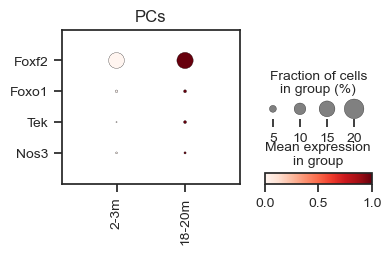

In [120]:
sc.pl.dotplot(adata_pcs, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="PCs")

### SMCs only

In [121]:
adata_pcs = adata[adata.obs['clusters'].isin(['SMCs'])]
pd.value_counts(adata_pcs.obs["age"])

2-3m      1023
18-20m     402
Name: age, dtype: int64

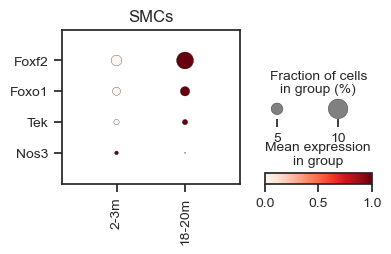

In [122]:
sc.pl.dotplot(adata_pcs, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="SMCs")

### Neurons only

In [123]:
adata_neur = adata[adata.obs['clusters'].isin(['Neurons'])]
pd.value_counts(adata_neur.obs["age"])

2-3m      1211
18-20m     206
Name: age, dtype: int64

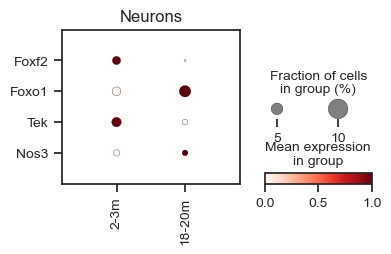

In [124]:
sc.pl.dotplot(adata_neur, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Neurons")

### Astrocytes only

In [125]:
adata_astro = adata[adata.obs['clusters'].isin(['Astrocytes'])]
pd.value_counts(adata_astro.obs["age"])

2-3m      7121
18-20m    2521
Name: age, dtype: int64

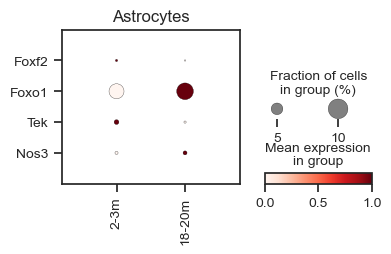

In [126]:
sc.pl.dotplot(adata_astro, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Astrocytes")

### Oligos only

In [127]:
adata_olig = adata[adata.obs['clusters'].isin(['Oligos'])]
pd.value_counts(adata_olig.obs["age"])

2-3m      170
18-20m     66
Name: age, dtype: int64

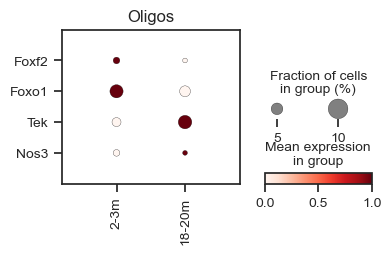

In [128]:
sc.pl.dotplot(adata_olig, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Oligos")

### Microglia only

In [129]:
adata_mg = adata[adata.obs['clusters'].isin(['Microglia/Macrophages'])]
pd.value_counts(adata_mg.obs["age"])

2-3m      9713
18-20m    3173
Name: age, dtype: int64

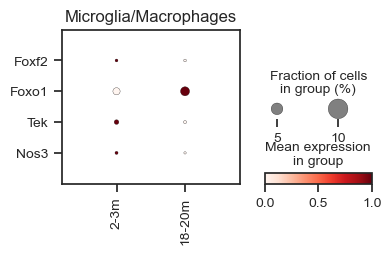

In [130]:
sc.pl.dotplot(adata_mg, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Microglia/Macrophages")

## Correlate gene expression (Foxf2 and Foxo1)

### ECs

In [131]:
gg = ["Foxf2","Foxo1"]

In [132]:
adata

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [133]:
adata_ecs

View of AnnData object with n_obs × n_vars = 12357 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [134]:
adat = adata_ecs
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

Foxf2  Foxo1     age
B1_AAAGTAGGTGTGTGCC  0.000000    0.0  18-20m
B1_AAATGCCAGCGGATCA  2.095264    0.0  18-20m
B1_AACGTTGCACCACGTG  1.404646    0.0  18-20m
B1_AACTCAGAGGATATAC  0.000000    0.0  18-20m
B1_AACTGGTTCGCAGGCT  1.677397    0.0  18-20m

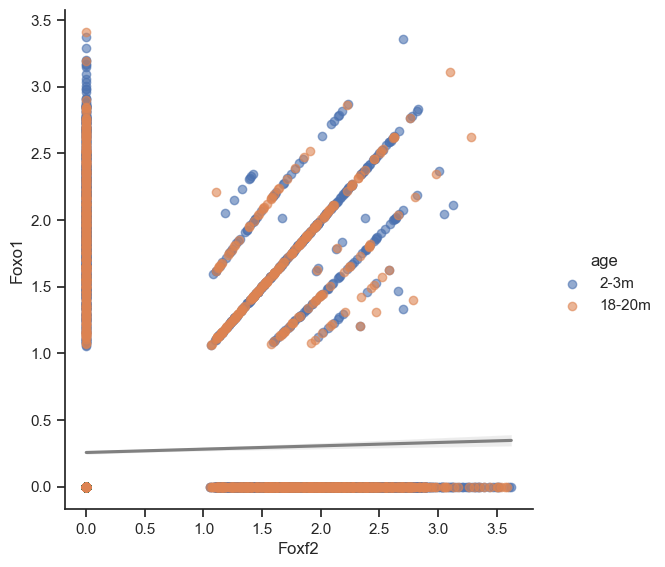

In [135]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [136]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.03, p = 0.00026'

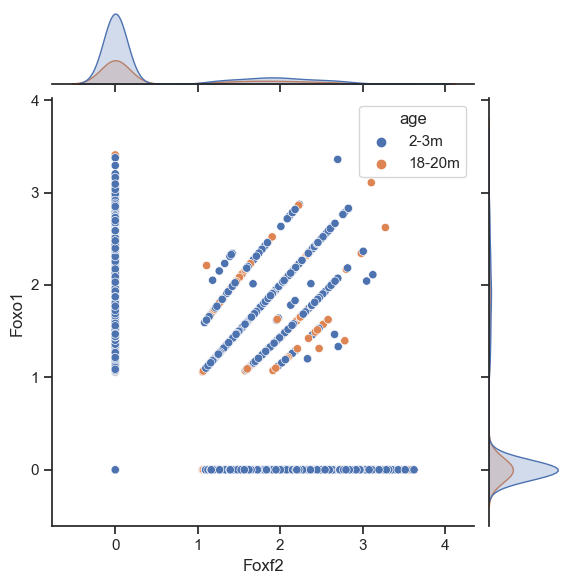

In [137]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

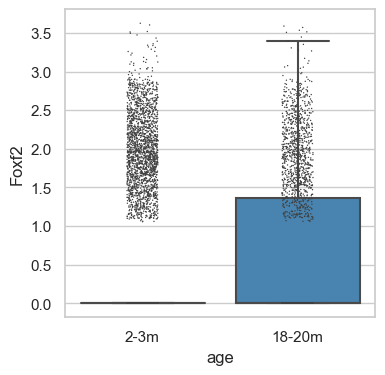

In [141]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxf2", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxf2", data=subs, color=".25",size=1)
plt.show()

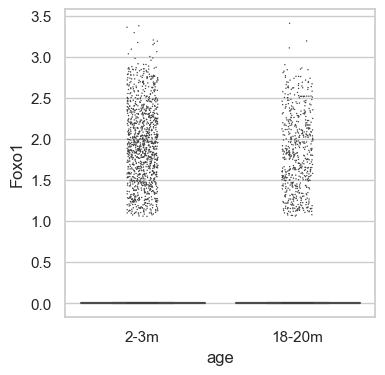

In [142]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxo1", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxo1", data=subs, color=".25",size=1)
plt.show()

Exclude dropouts (cells with 0 expression of both genes)

In [143]:
coex = (adata_ecs[:,'{}'.format("Foxf2")].X > 0) | (adata_ecs[:,'{}'.format("Foxo1")].X > 0)

In [144]:
adata_ecs_above0 = adata_ecs[coex]
adata_ecs_above0

View of AnnData object with n_obs × n_vars = 4366 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [145]:
pd.value_counts(adata_ecs_above0.obs["age"])

2-3m      2929
18-20m    1437
Name: age, dtype: int64

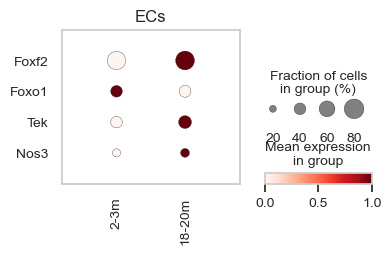

In [146]:
sc.pl.dotplot(adata_ecs_above0, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="ECs")

In [147]:
adat = adata_ecs_above0
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)

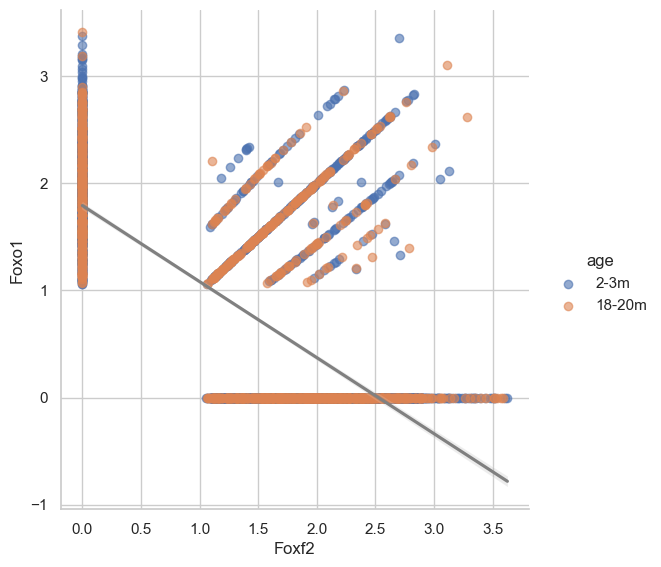

In [148]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [149]:
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = -0.70, p = 0'

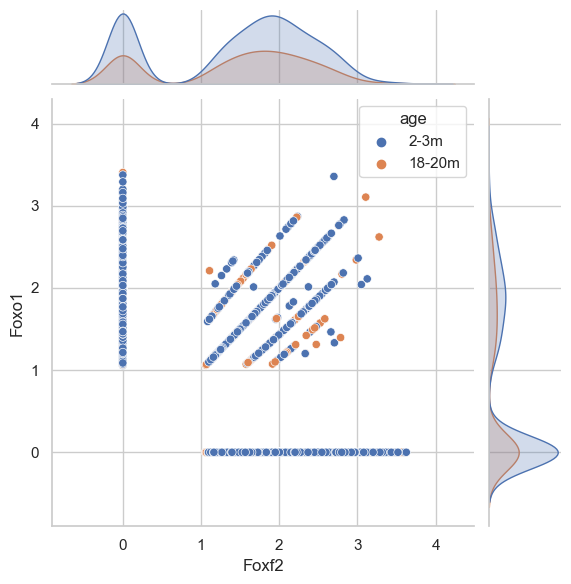

In [150]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

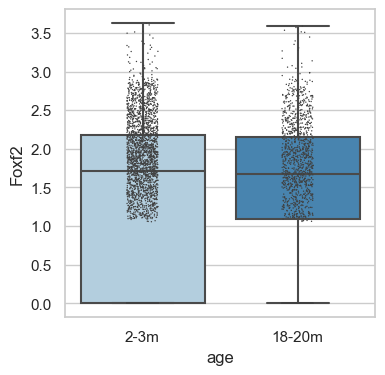

In [151]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxf2", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxf2", data=subs, color=".25",size=1)
plt.show()

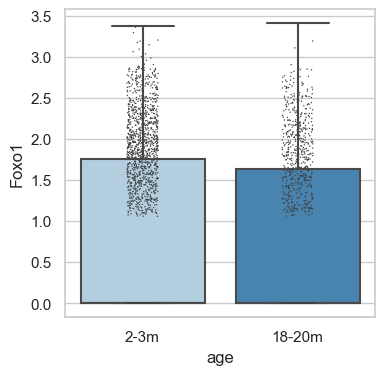

In [152]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxo1", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxo1", data=subs, color=".25",size=1)
plt.show()

Exclude dropouts (cells with 0 expression of any of the 2 genes)

In [153]:
coex = (adata_ecs[:,'{}'.format("Foxf2")].X > 0) & (adata_ecs[:,'{}'.format("Foxo1")].X > 0)

In [154]:
adata_ecs_above0 = adata_ecs[coex]
adata_ecs_above0

View of AnnData object with n_obs × n_vars = 609 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [155]:
pd.value_counts(adata_ecs_above0.obs["age"])

2-3m      376
18-20m    233
Name: age, dtype: int64

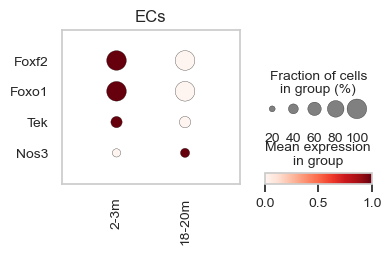

In [156]:
sc.pl.dotplot(adata_ecs_above0, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="ECs")

In [157]:
adat = adata_ecs_above0
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)

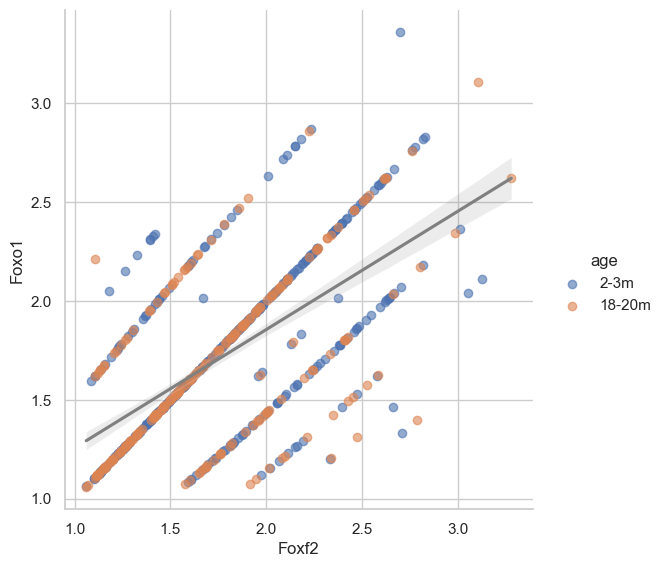

In [158]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [159]:
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.63, p = 3.1e-68'

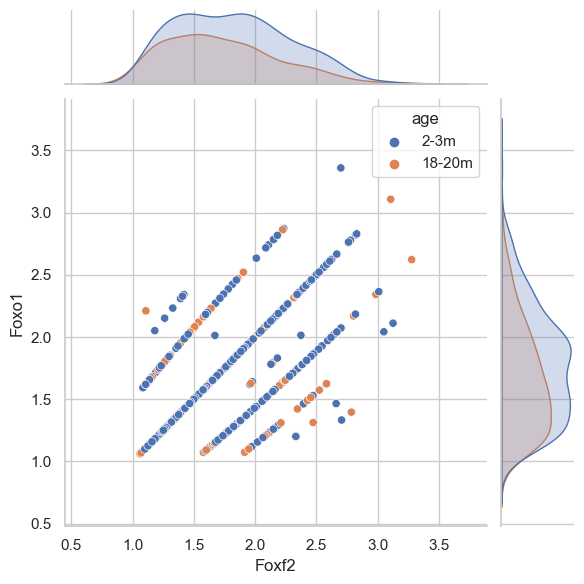

In [160]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

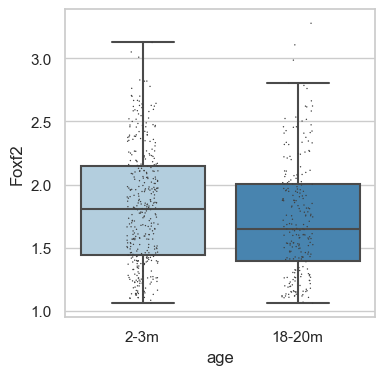

In [161]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxf2", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxf2", data=subs, color=".25",size=1)
plt.show()

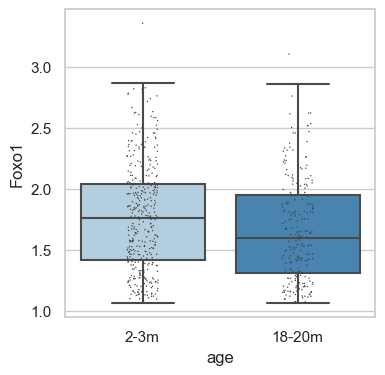

In [162]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxo1", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxo1", data=subs, color=".25",size=1)
plt.show()

### All cell types

In [150]:
gg = ["Foxf2","Foxo1"]

In [151]:
adata

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'sublusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [152]:
adat = adata
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

Foxf2  Foxo1     age
B1_AAACGGGGTAGTGAAT    0.0    0.0  18-20m
B1_AAAGATGGTCCGAGTC    0.0    0.0  18-20m
B1_AAAGCAAGTACCTACA    0.0    0.0  18-20m
B1_AAAGCAAGTAGGCATG    0.0    0.0  18-20m
B1_AAAGCAAGTCCTCTTG    0.0    0.0  18-20m

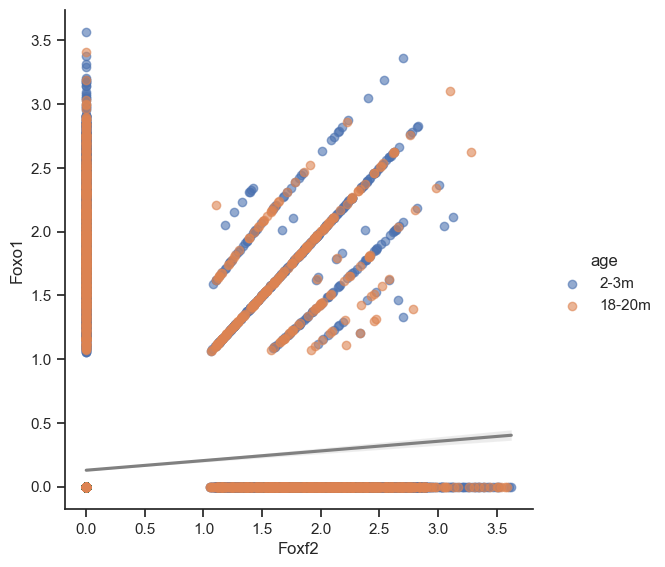

In [153]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

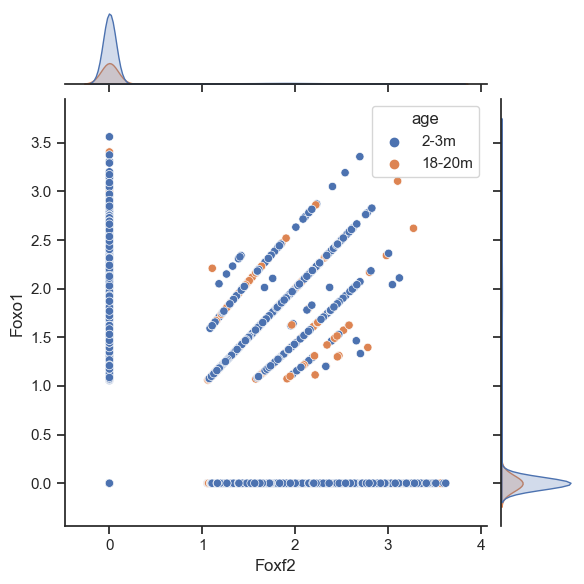

In [154]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

Exclude dropouts (cells with 0 expression of both genes)

In [155]:
coex = (adat[:,'{}'.format("Foxf2")].X > 0) | (adat[:,'{}'.format("Foxo1")].X > 0)

In [156]:
adata_above0 = adat[coex]
adata_above0

View of AnnData object with n_obs × n_vars = 6238 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'sublusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [157]:
pd.value_counts(adata_above0.obs["age"])

2-3m      4245
18-20m    1993
Name: age, dtype: int64

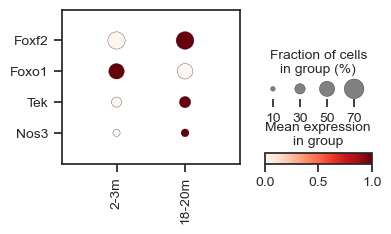

In [158]:
sc.pl.dotplot(adata_above0, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized")

In [159]:
adat = adata_above0
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)

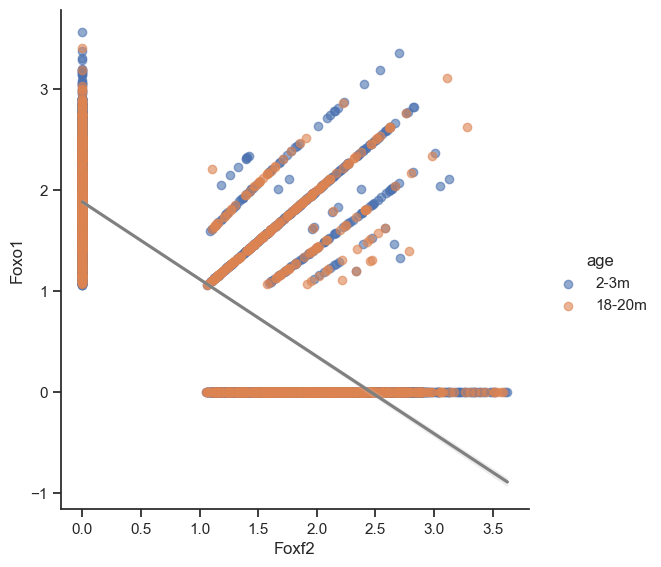

In [160]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

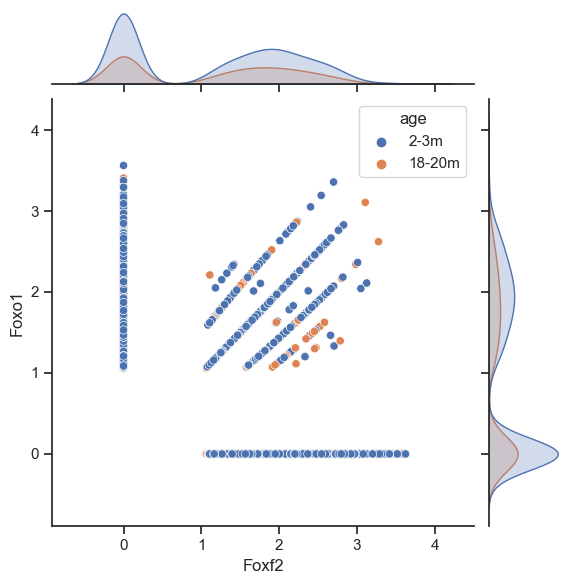

In [161]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

## Impute expression values of dropouts  
Using MAGIC

In [164]:
import magic

In [166]:
fdata = pd.DataFrame(adata.X, columns = adata.var_names)
fdata.head()

Rp1  Sox17  Mrpl15  Lypla1    Tcea1  Rgs20   Atp6v1h  Rb1cc1  \
0  0.0    0.0     0.0     0.0  2.37106    0.0  0.000000     0.0   
1  0.0    0.0     0.0     0.0  0.00000    0.0  0.000000     0.0   
2  0.0    0.0     0.0     0.0  2.12229    0.0  1.542255     0.0   
3  0.0    0.0     0.0     0.0  0.00000    0.0  0.000000     0.0   
4  0.0    0.0     0.0     0.0  0.00000    0.0  0.000000     0.0   

   4732440D04Rik    Pcmtd1  ...  C330002G04Rik  Mlana  Ffar4  Ankrd2  Gm16541  \
0            0.0  0.000000  ...            0.0    0.0    0.0     0.0      0.0   
1            0.0  0.000000  ...            0.0    0.0    0.0     0.0      0.0   
2            0.0  1.542255  ...            0.0    0.0    0.0     0.0      0.0   
3            0.0  0.000000  ...            0.0    0.0    0.0     0.0      0.0   
4            0.0  0.000000  ...            0.0    0.0    0.0     0.0      0.0   

   Hpse2  Gm45352  AC133103.1  Gm10931  AC125149.2  
0    0.0      0.0         0.0      0.0         0.0  
1    0.0      0.0         0.0      0.0         0.0  
2    0.0      0.0         0.0      0.0         0.0  
3    0.0      0.0         0.0      0.0         0.0  
4    0.0      0.0         0.0      0.0         0.0  

[5 rows x 19746 columns]

In [167]:
magic_op = magic.MAGIC()

In [168]:
f_magic = magic_op.fit_transform(fdata)

Calculating MAGIC...
  Running MAGIC on 43922 cells and 19746 genes.
  Calculating graph and diffusion operator...


C:\Users\sfrerich\AppData\Roaming\Python\Python38\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculating PCA...
    Calculated PCA in 19.82 seconds.
    Calculating KNN search...
    Calculated KNN search in 214.35 seconds.
    Calculating affinities...
    Calculated affinities in 215.14 seconds.
  Calculated graph and diffusion operator in 451.04 seconds.
  Running MAGIC with `solver='exact'` on 19746-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 58.56 seconds.
Calculated MAGIC in 511.68 seconds.


In [170]:
import scprep

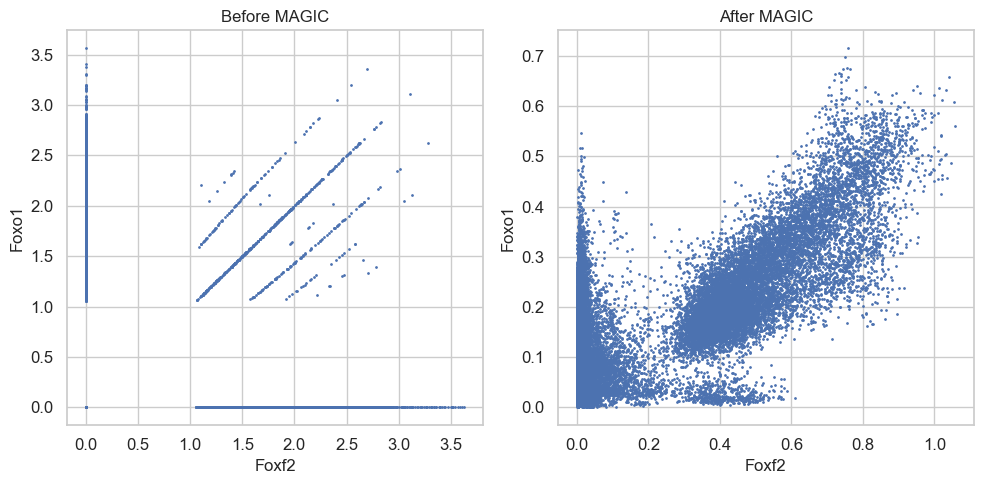

In [181]:
gene1="Foxf2"
gene2="Foxo1"
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
scprep.plot.scatter(x=fdata[gene1], y=fdata[gene2], ax=ax1, xlabel=gene1, ylabel=gene2, legend_title=gene3, title='Before MAGIC')
scprep.plot.scatter(x=f_magic[gene1], y=f_magic[gene2], ax=ax2, xlabel=gene1, ylabel=gene2, legend_title=gene3, title='After MAGIC')
plt.tight_layout()
plt.show()

In [184]:
adata.X.shape

(43922, 19746)

In [185]:
f_magic.shape

(43922, 19746)

In [186]:
adata.layers["imputed"] = f_magic

In [187]:
# ECs only
adata_ecs = adata[adata.obs['clusters'].isin(['Endothelial cells'])]
adata_ecs

View of AnnData object with n_obs × n_vars = 12357 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized', 'imputed'

### ECs

In [236]:
gg = ["Foxf2","Foxo1"]

In [237]:
adata

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized', 'imputed'

In [238]:
adata_ecs

View of AnnData object with n_obs × n_vars = 12357 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized', 'imputed'

In [239]:
adat = adata_ecs
subs = adat[:,gg].layers["imputed"]
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

Foxf2     Foxo1     age
B1_AAAGTAGGTGTGTGCC  0.659133  0.155660  18-20m
B1_AAATGCCAGCGGATCA  0.426251  0.182095  18-20m
B1_AACGTTGCACCACGTG  0.654212  0.153928  18-20m
B1_AACTCAGAGGATATAC  0.697572  0.282966  18-20m
B1_AACTGGTTCGCAGGCT  0.583229  0.144305  18-20m

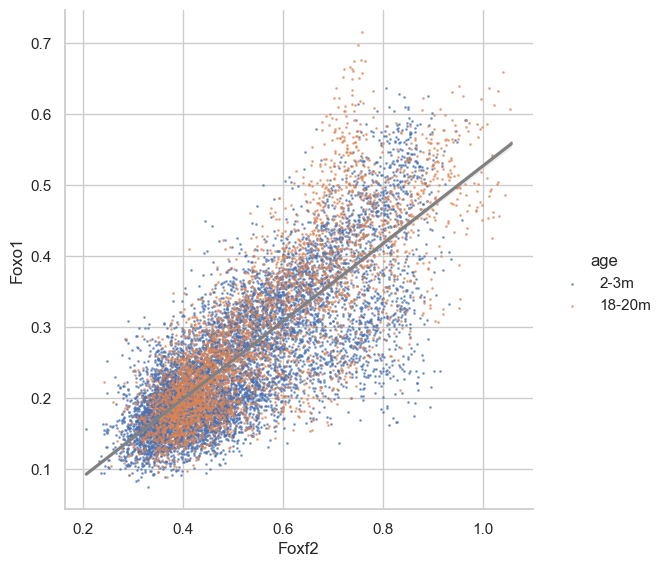

In [240]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6,"s":1})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [241]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.80, p = 0'

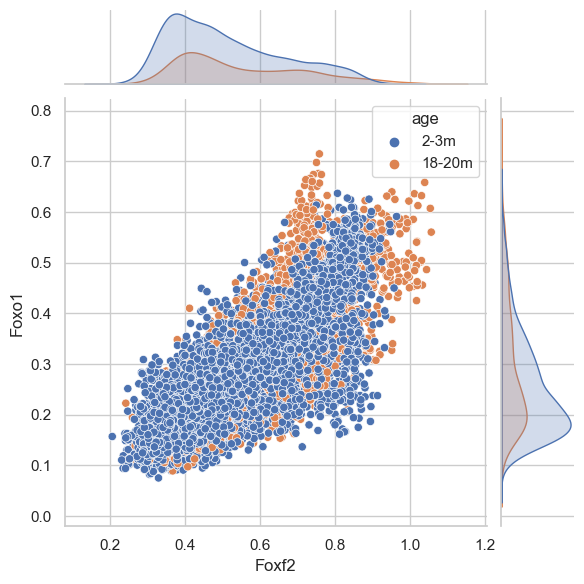

In [242]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

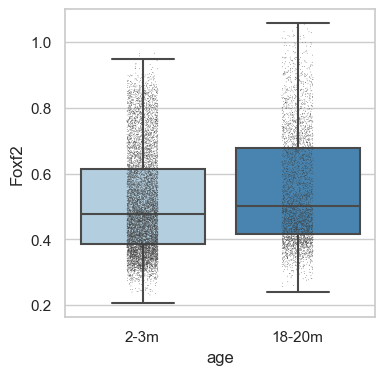

In [243]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxf2", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxf2", data=subs, color=".25",size=0.5)
plt.show()

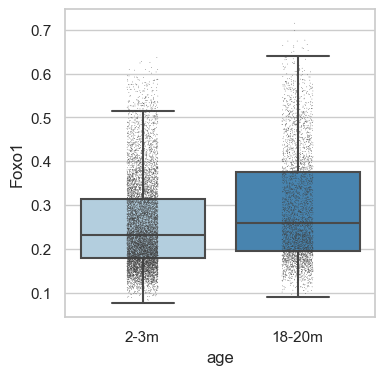

In [244]:
sns.set(style="whitegrid")
ax = sns.boxplot(x="age", y="Foxo1", data=subs, showfliers = False, palette="Blues")
ax = sns.stripplot(x="age", y="Foxo1", data=subs, color=".25",size=0.5)
plt.show()

### All cell types

In [286]:
gg = ["Foxf2","Foxo1"]

In [287]:
adata

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized', 'imputed'

In [288]:
adat = adata
subs = adat[:,gg].layers["imputed"]
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

Foxf2     Foxo1     age
B1_AAACGGGGTAGTGAAT  0.003854  0.013373  18-20m
B1_AAAGATGGTCCGAGTC  0.009960  0.065180  18-20m
B1_AAAGCAAGTACCTACA  0.007321  0.225210  18-20m
B1_AAAGCAAGTAGGCATG  0.002767  0.030573  18-20m
B1_AAAGCAAGTCCTCTTG  0.003214  0.028512  18-20m

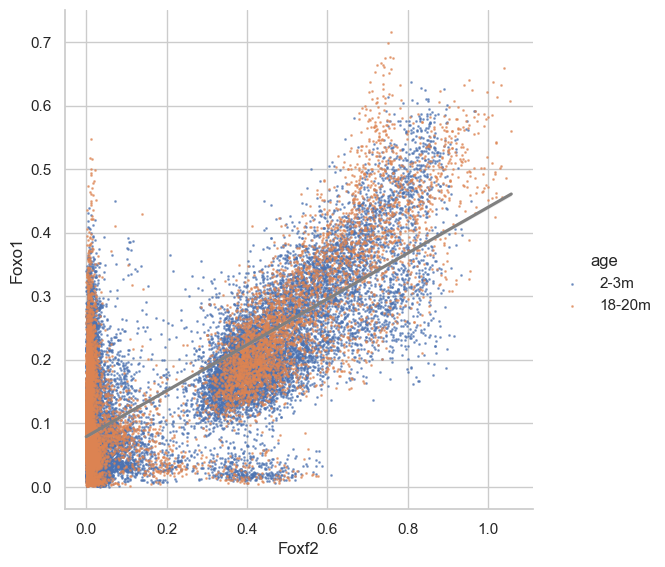

In [289]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6,"s":1})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [290]:
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.77, p = 0'

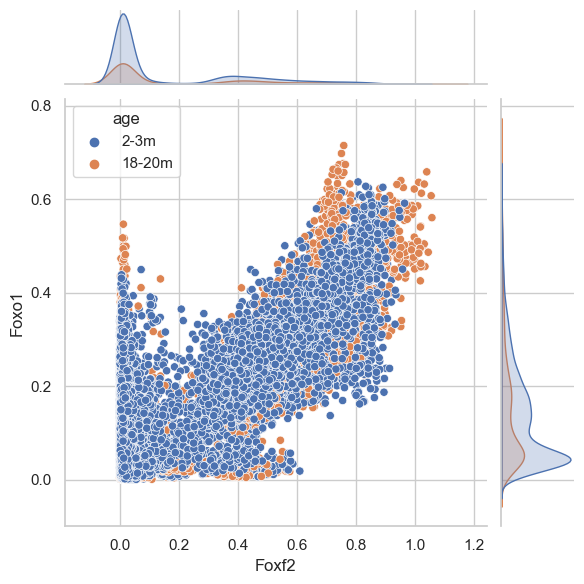

In [291]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

## Pseudobulk analysis

Because correlation on single cell level is biased by large number of dropouts

In [162]:
import decoupler as dc

In [163]:
adata

AnnData object with n_obs × n_vars = 43922 × 19746
    obs: 'orig.ident', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Celltype', 'Subtype', 'seurat_clusters', 'age2', 'age', 'clusters', 'sublusters', 'subclusters', 'clusters2'
    var: 0, 1
    uns: 'Celltype_colors', 'Age_colors', 'Subtype_colors'
    obsm: 'X_tsne'
    layers: 'normalized'

In [164]:
adata.obs["sample"] = adata.obs["orig.ident"]

In [165]:
pd.value_counts(adata.obs["sample"])

young4    15019
young2     9143
young1     7393
old2       5932
old4       5497
old1        938
Name: sample, dtype: int64

In [166]:
pd.crosstab(adata.obs["sample"], adata.obs["age"]).T

sample  old1  old2  old4  young1  young2  young4
age                                             
2-3m       0     0     0    7393    9143   15019
18-20m   938  5932  5497       0       0       0

In [167]:
padata = dc.get_pseudobulk(adata, sample_col='sample', groups_col=None, layer='normalized', min_prop=0.01, min_smpls=0)

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\decoupler\utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)


In [168]:
padata

View of AnnData object with n_obs × n_vars = 6 × 11897
    obs: 'orig.ident', 'Batch', 'age2', 'age', 'sample'

### Correlate gene expression (Foxf2 and Foxo1)

#### All cell types

In [169]:
gg = ["Foxf2","Foxo1"]

In [170]:
padata

View of AnnData object with n_obs × n_vars = 6 × 11897
    obs: 'orig.ident', 'Batch', 'age2', 'age', 'sample'

In [171]:
adat = padata
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

Foxf2        Foxo1     age
old1     237.319473   120.097404  18-20m
old2    1215.464844   982.498413  18-20m
old4     904.626221   807.857239  18-20m
young1  1388.902466   930.350891    2-3m
young2  1406.753906  1265.766968    2-3m

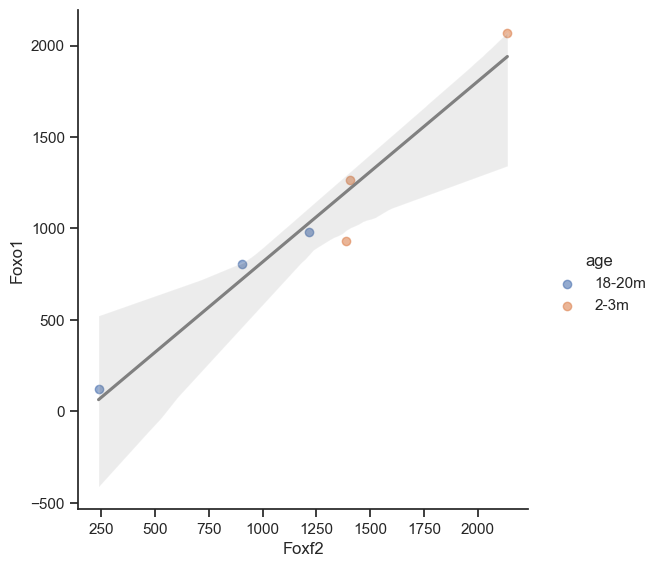

In [172]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [173]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.97, p = 0.001'

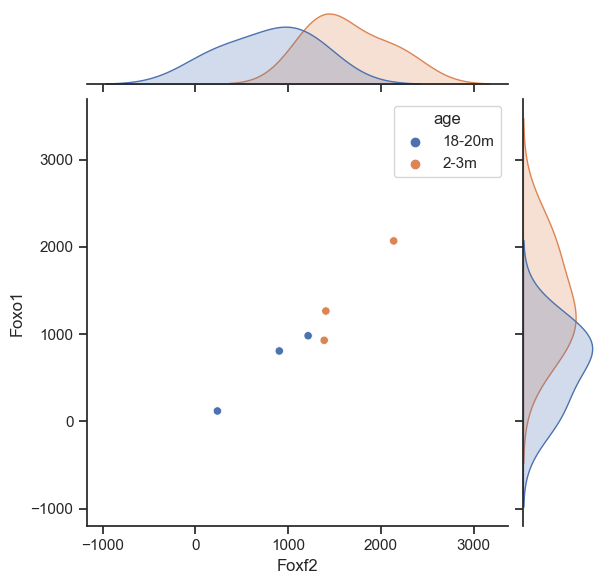

In [174]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

#### ECs

In [175]:
padata = dc.get_pseudobulk(adata, sample_col='sample', groups_col='clusters', layer='normalized', min_prop=0.1, min_smpls=3)

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\decoupler\utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)


In [176]:
padata

View of AnnData object with n_obs × n_vars = 59 × 5744
    obs: 'orig.ident', 'Batch', 'age2', 'age', 'clusters', 'sample'

In [177]:
# ECs only
padata_ecs = padata[padata.obs['clusters'].isin(['Endothelial cells'])]
padata_ecs

View of AnnData object with n_obs × n_vars = 6 × 5744
    obs: 'orig.ident', 'Batch', 'age2', 'age', 'clusters', 'sample'

In [178]:
gg = ["Foxf2","Foxo1"]

In [179]:
adat = padata_ecs
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

Foxf2       Foxo1     age
old1_Endothelial cells     207.674942   55.326614  18-20m
old2_Endothelial cells    1105.592285  580.137939  18-20m
old4_Endothelial cells     783.696838  438.132874  18-20m
young1_Endothelial cells  1191.642456  508.812561    2-3m
young2_Endothelial cells  1278.026367  778.909363    2-3m

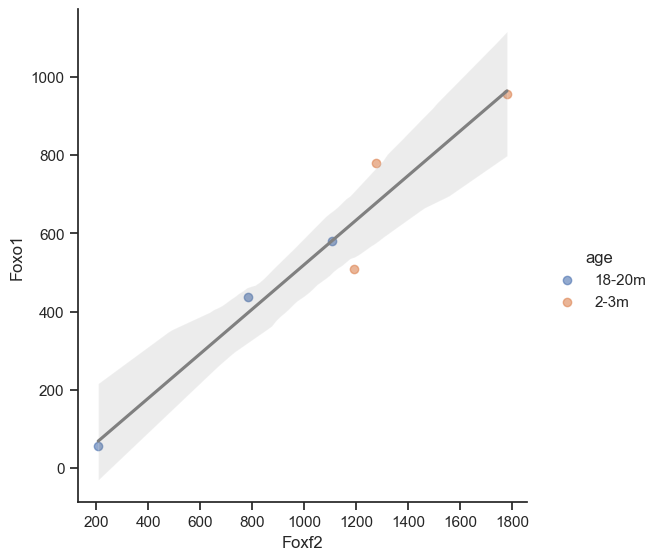

In [180]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [181]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.97, p = 0.0012'

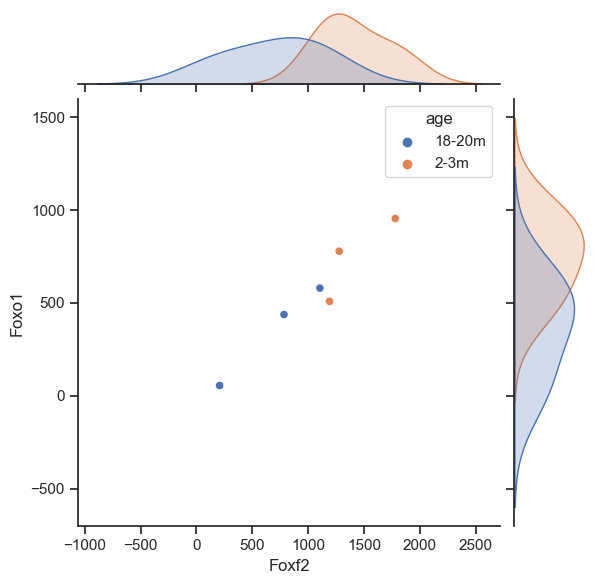

In [182]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

# Session Info

In [183]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.1.0
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi    

---
# Export HTML

In [ ]:
# use nbconvert conda env

In [ ]:
! cp sc_pp_Zhao2022.ipynb HTMLs/$(date '+%Y%m%d')_sc_pp_Zhao2022.ipynb # rename in temp copy
! jupyter nbconvert HTMLs/$(date '+%Y%m%d')_sc_pp_Zhao2022.ipynb --to html_toc # export
! rm HTMLs/$(date '+%Y%m%d')_sc_pp_Zhao2022.ipynb # delete temp copy